# 地方競馬（NAR）血統導入モデル (17モデル)

父馬 (sire_id) の過去成績を集計し、血統傾向（Target Encoding）を特徴量として導入します。

### 仮説
- **仮説**: 特にクラス変動時や初コース時、または若駒において、自身の過去成績よりも血統的なポテンシャルが結果に影響する。
- **実装**: 時系列に沿った expanding mean で `sire_win_rate`, `sire_place_rate` を計算しモデルに投入。

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import japanize_matplotlib

# プロジェクトのsrcディレクトリをパスに追加
src_path = os.path.abspath(os.path.join(os.getcwd(), '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from nar.loader import NarDataLoader
from nar.features import NarFeatureGenerator

%matplotlib inline
sns.set(font='IPAexGothic', style='whitegrid')

/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
loader = NarDataLoader()
# データ量は多めに確保
raw_df = loader.load(limit=200000, region='south_kanto')

generator = NarFeatureGenerator(history_windows=[1, 2, 3, 4, 5])
df = generator.generate_features(raw_df)

df = df.dropna(subset=['rank']).copy()
df['date'] = pd.to_datetime(df['date'])

# 特徴量定義
baseline_features = [
    'distance', 'venue', 'state', 'frame_number', 'horse_number', 'weight', 'impost',
    'jockey_win_rate', 'jockey_place_rate', 'trainer_win_rate', 'trainer_place_rate',
    'horse_run_count'
] + [col for col in df.columns if 'horse_prev' in col]

advanced_features = [
    'gender', 'age', 'days_since_prev_race', 'weight_diff',
    'horse_jockey_place_rate', 'is_consecutive_jockey',
    'distance_diff', 'horse_venue_place_rate',
    'trainer_30d_win_rate',
    'impost_diff', 'was_accident_prev1', 'weighted_si_momentum', 'weighted_rank_momentum',
    'class_rank', 'class_diff', 'is_promoted', 'is_demoted'
]

phase9_features = [
    'weighted_si_momentum_race_rank', 'weighted_si_momentum_diff_from_avg', 'weighted_si_momentum_zscore',
    'weighted_rank_momentum_race_rank', 'weighted_rank_momentum_diff_from_avg', 'weighted_rank_momentum_zscore',
    'class_rank_race_rank', 'class_rank_diff_from_avg', 'class_rank_zscore',
    'horse_state_place_rate', 'season', 'is_night_race', 'trainer_momentum_bias'
]

pedigree_features = [
    'sire_win_rate', 'sire_place_rate'
]

features = list(set(baseline_features + advanced_features + phase9_features + pedigree_features))

# カテゴリ処理
categorical_cols = ['venue', 'state', 'gender', 'season']
for col in features:
    if col in df.columns:
        if col in categorical_cols:
            df[col] = df[col].astype(str).astype('category')
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')

features = [f for f in features if f in df.columns]

split_date = df['date'].quantile(0.8)
train_df = df[df['date'] < split_date].sort_values('race_id').copy()
test_df = df[df['date'] >= split_date].sort_values('race_id').copy()

print(f'Train: {len(train_df)}, Test: {len(test_df)}')

重複データを削除しました: 200000 -> 193051 件
/workspace/src/nar/features.py:540: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sire_win_rate'] = (cum_wins / cum_runs.replace(0, np.nan)).fillna(0.0)
/workspace/src/nar/features.py:541: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sire_place_rate'] = (cum_places / cum_runs.replace(0, np.nan)).fillna(0.0)


Train: 40882, Test: 10293


In [3]:
# NB13の最適パラメータを使用
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [1, 3, 5],
    'n_estimators': 1000,
    'learning_rate': 0.05, # NB13 tuned value approx
    'num_leaves': 64,
    'max_depth': 6,
    'random_state': 42,
    'importance_type': 'gain'
}

train_groups = train_df.groupby('race_id').size().values
test_groups = test_df.groupby('race_id').size().values
train_label = 20 - train_df['rank']
test_label = 20 - test_df['rank']

model = lgb.LGBMRanker(**params)
model.fit(
    train_df[features], train_label,
    group=train_groups,
    eval_set=[(test_df[features], test_label)],
    eval_group=[test_groups],
    eval_at=[1, 3, 5],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7890
[LightGBM] [Info] Number of data points in the train set: 40882, number of used features: 61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRanker(importance_type='gain', learning_rate=0.05, max_depth=6,
           metric='ndcg', n_estimators=1000, ndcg_at=[1, 3, 5], num_leaves=64,
           objective='lambdarank', random_state=42)

血統導入モデル予測精度:
   predicted_rank  win_rate  place_rate
0               1  0.325370    0.651877
1               2  0.184300    0.505119
2               3  0.109215    0.383390
3               4  0.098976    0.359499
4               5  0.069397    0.277588
Spearman相関係数: 0.4635


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


<Figure size 1000x1000 with 0 Axes>

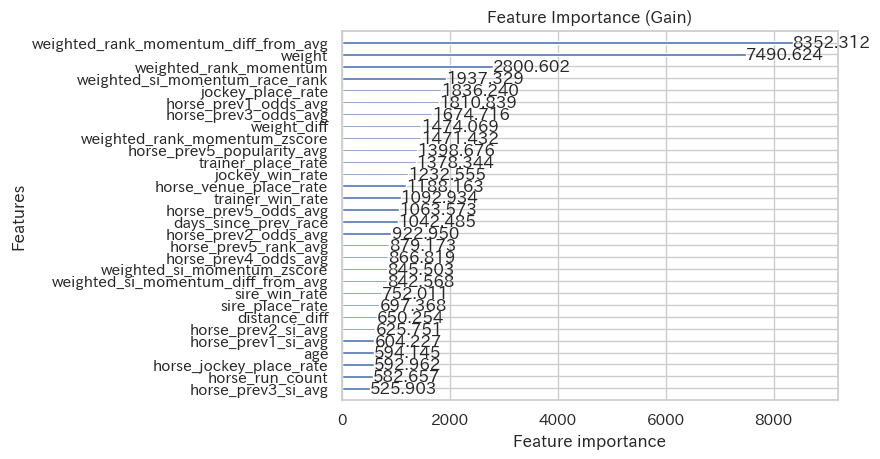

In [4]:
test_df['pred_score'] = model.predict(test_df[features])
test_df['pred_rank'] = test_df.groupby('race_id')['pred_score'].rank(method='min', ascending=False)

eval_list = []
for r in range(1, 6):
    matches = test_df[test_df['pred_rank'] == r]
    win_rate = (matches['rank'] == 1).mean()
    place_rate = (matches['rank'] <= 3).mean()
    eval_list.append({'predicted_rank': r, 'win_rate': win_rate, 'place_rate': place_rate})

eval_df = pd.DataFrame(eval_list)
print('血統導入モデル予測精度:')
print(eval_df)

corr, _ = spearmanr(test_df['pred_score'], 20-test_df['rank'])
print(f'Spearman相関係数: {corr:.4f}')

# 重要度表示
plt.figure(figsize=(10, 10))
lgb.plot_importance(model, max_num_features=30, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()